In [ ]:
%pip install category_encoders

In [ ]:
import time, warnings
import pandas as pd
import numpy as np

from scipy.stats import randint, uniform
from sklearn.model_selection import PredefinedSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from category_encoders.hashing import HashingEncoder
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import TargetEncoder
from sklearn.model_selection import KFold

In [ ]:
df = pd.read_csv('InstaCart.csv')

In [ ]:
df.head()

,product_id,product_name,aisle_id,department_id,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered,department,aisle
0,16617,Organic Muenster Cheese Slices,21,16,2055979.0,1097.0,prior,1.0,2.0,14.0,0.0,8.0,0.0,dairy eggs,packaged cheese
1,21267,Sourdough Bread,112,3,2055979.0,1097.0,prior,1.0,2.0,14.0,0.0,3.0,0.0,bakery,bread
2,24561,Organic Cheese Frozen Pizza,79,1,2055979.0,1097.0,prior,1.0,2.0,14.0,0.0,1.0,0.0,frozen,frozen pizza
3,24852,Banana,24,4,2055979.0,1097.0,prior,1.0,2.0,14.0,0.0,2.0,0.0,produce,fresh fruits
4,27344,Uncured Genoa Salami,96,20,2055979.0,1097.0,prior,1.0,2.0,14.0,0.0,6.0,0.0,deli,lunch meat


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51613 entries, 0 to 51612
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   product_id              51613 non-null  int64  
 1   product_name            51613 non-null  object 
 2   aisle_id                51613 non-null  int64  
 3   department_id           51613 non-null  int64  
 4   order_id                51613 non-null  float64
 5   user_id                 51613 non-null  float64
 6   eval_set                51613 non-null  object 
 7   order_number            51613 non-null  float64
 8   order_dow               51613 non-null  float64
 9   order_hour_of_day       51613 non-null  float64
 10  days_since_prior_order  51613 non-null  float64
 11  add_to_cart_order       51613 non-null  float64
 12  reordered               51613 non-null  float64
 13  department              51613 non-null  object 
 14  aisle                   51613 non-null

In [ ]:
df.reordered.value_counts()

,count
reordered,
1.0,28781
0.0,22832


In [ ]:
df.product_name.nunique()

9222

In [ ]:
df.eval_set.nunique()

1

In [ ]:
df.department.nunique()

21

In [ ]:
df.aisle.nunique()

134

In [ ]:
df = df.drop(columns=['eval_set'])

## Деление на train, validation и test

Разделим данные на три выборки в отношении 60/20/20 процентов. После обучения моделей на train будет произведен подбор гиперпараметров на validation, потом модель будет заново обучена на 80%-ой выборке и протестирована на test.

In [ ]:
warnings.filterwarnings('ignore')
RND = 42
np.random.seed(RND)

TARGET = 'reordered'

train_df, val_df, test_df = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])
print(f'Train: {train_df.shape}')
print(f'Validation: {val_df.shape}')
print(f'Test: {test_df.shape}')

Train: (30967, 14)
Validation: (10323, 14)
Test: (10323, 14)


## Transformers

Перед обучением моделей также стоит предобработать уже готовый датасет, чтобы обучение моделей и подбор гиперпараметров занимали меньше времени, а также проводились на приведенных в одинаковый формат данных.

Стандартизация данных (StandardScaler) в нашем случае помогает работе моделей, основанных на градиентном спуске (logistic regression и MLP), а также KNN.

PCA же уменьшает размерность, сохраняя при это 95% дисперсии, чтобы ускорить обучение и избежать переобучения.

В случае с категориальными переменными, столбцы с низким числом уникальных значений были преобразованы one-hot encoder-ом, а столбец product_name, в связи с большой кардинальностью, был закодирован target encoder-ом.

In [ ]:
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.drop(TARGET)
cat_cols = train_df.select_dtypes(include=['object']).columns

num_pipe = Pipeline([
    ('sc',  StandardScaler()),
    ('pca', PCA(n_components=0.95, random_state=RND))
])

cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore', min_frequency=1))
])

te = TargetEncoder(
        cv=5,
        random_state=RND
)


cat_pipe_prod = Pipeline([
    ('te', te)
])

prep = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, ['aisle', 'department']),
    ('cat_prod',  cat_pipe_prod, ['product_name'])
])

## Выбор моделей и подбор параметров

Logistic Regression — базовый, быстрообучаемый алгоритм, который как раз подходит для нашей задачи бинарной классификации (reordered = 1 или 0), и от его точности можно будет отталкиваться, сравнивая с более сложными моделями

kNN взят как один из базовых алгоритмов классификации, тоже подходит для бейзлайна


Random Forest - очередной алгоритм, часто показывающий высокую точность, редко переобучается. Он способен качественно обрабатывать большие наборы данных с множеством приизнаков

MLP-Classifier - многослойный перцептрон, способный выявлять сложные связи между товарами, временем и пользовательскими привычками, что, возможно, позволит лучше предсказывать повторную покупку товаров

XGBoost - одна из самых эффективных моделей для задач классификации, часто показывающая высокую точность. Также он хорошо подходит для огромных датасетов и легче масштабируется, что идеально подходит под нашу бизнес-задачу, которая на настоящих данных будет иметь миллионы строк

In [ ]:
models = {
    'LogReg': LogisticRegression(max_iter=4000, class_weight='balanced',
                                 n_jobs=-1, random_state=RND),
    'kNN': KNeighborsClassifier(),
    'RandomForest': RandomForestClassifier(class_weight='balanced',
                                           n_jobs=-1, random_state=RND),
    'MLP': MLPClassifier(max_iter=200, early_stopping=True, random_state=RND),
    'XGBoost': XGBClassifier(objective='binary:logistic', eval_metric='auc',
                             n_jobs=-1, random_state=RND, tree_method='hist'
    )
}

param_grid = {
    'LogReg': {
        'model__C': uniform(0.01, 5),
        'model__penalty': ['l1', 'l2']
    },
    'kNN': {
        'model__n_neighbors': randint(10, 30),
        'model__weights': ['uniform', 'distance'],
        'model__p': [1, 2]
    },
    'RandomForest': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [15, 30],
        'model__max_features': ['sqrt', 'log2']
    },
    'MLP': {
        'model__hidden_layer_sizes': [(256,128), (128,64), (64,32)],
        'model__alpha': uniform(1e-5, 1e-2),
        'model__learning_rate_init': uniform(1e-4, 5e-3),
        'model__batch_size': [128, 256, 512]
    },
    'XGBoost': {
        'model__n_estimators': randint(300, 600),
        'model__max_depth': randint(3, 7),
        'model__learning_rate': uniform(0.03, 0.2),
        'model__subsample': uniform(0.6, 0.4),
        'model__colsample_bytree': uniform(0.6, 0.4),
        'model__reg_lambda': uniform(0, 2)
    }
}

Теперь объединим тренировочную и валидационную выборки для подбора гиперпараметров. Сами гиперпараметры будем подбирать через случайный поиск - метод, который выбирает случайные комбинации параметров из заданного ранее пространства параметров и оценивает их, чтобы найти наиболее оптимальное решение.

Гиперпараметры ищутся по валидационной выборке, то есть где test_fold = 0

In [ ]:
X_tv = pd.concat([train_df.drop(columns=[TARGET]), val_df.drop(columns=[TARGET])])
y_tv = pd.concat([train_df[TARGET], val_df[TARGET]]).astype(int)

test_fold = np.concatenate([
    -1 * np.ones(len(train_df), dtype=int),
     0 * np.ones(len(val_df), dtype=int)
])
ps = PredefinedSplit(test_fold)

In [ ]:
results = []
best_pipes = {}
for name, base_model in models.items():
    print(f'\n{name}')
    pipe = Pipeline([('prep', prep), ('model', base_model)])

    search = RandomizedSearchCV(
        pipe, param_grid[name],
        n_iter=8, scoring='roc_auc',
        cv=ps, n_jobs=-1, random_state=RND, verbose=1, refit=True
    )

    t0 = time.time()
    search.fit(X_tv, y_tv)
    time_spent = time.time() - t0


    val_idx_mask = (test_fold == 0)
    X_val_ps, y_val_ps = X_tv.iloc[val_idx_mask], y_tv.iloc[val_idx_mask]
    proba_val = search.best_estimator_.predict_proba(X_val_ps)[:,1]
    pred_val  = (proba_val >= 0.5).astype(int)

    results.append({
        'Model': name,
        'ROC_AUC_val': roc_auc_score(y_val_ps, proba_val),
        'F1_val': f1_score(y_val_ps, pred_val),
        'Acc_val': accuracy_score(y_val_ps, pred_val),
        'time': round(time_spent, 1)
    })
    best_pipes[name] = search.best_estimator_

pd.DataFrame(results).sort_values('ROC_AUC_val', ascending=False)


LogReg
Fitting 1 folds for each of 8 candidates, totalling 8 fits

kNN
Fitting 1 folds for each of 8 candidates, totalling 8 fits

RandomForest
Fitting 1 folds for each of 8 candidates, totalling 8 fits

MLP
Fitting 1 folds for each of 8 candidates, totalling 8 fits

XGBoost
Fitting 1 folds for each of 8 candidates, totalling 8 fits


,Model,ROC_AUC_val,F1_val,Acc_val,time
1,kNN,0.999647,0.989814,0.988569,88.4
2,RandomForest,0.996329,0.971169,0.967354,241.2
4,XGBoost,0.901544,0.843414,0.809648,18.1
3,MLP,0.850457,0.797006,0.763538,58.8
0,LogReg,0.793781,0.731028,0.717427,4.0


## Обучение на подобранных параметрах и тестирование

Теперь обучим модели на итоговых параметрах, проведем тестирование и выведем показатели метрик точности

LogReg — обучение на train + validation
kNN — обучение на train + validation
RandomForest — обучение на train + validation
MLP — обучение на train + validation
XGBoost — обучение на train + validation


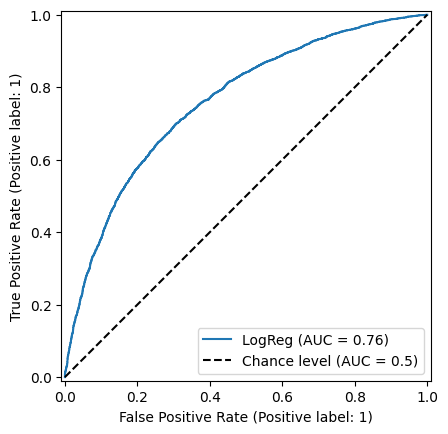

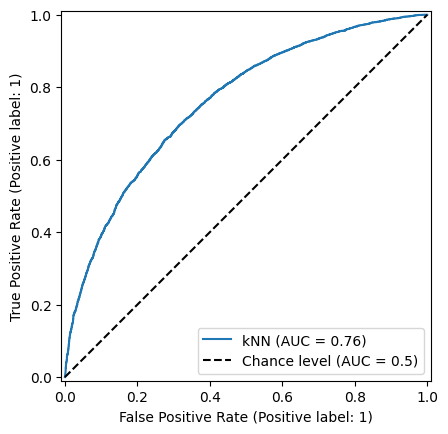

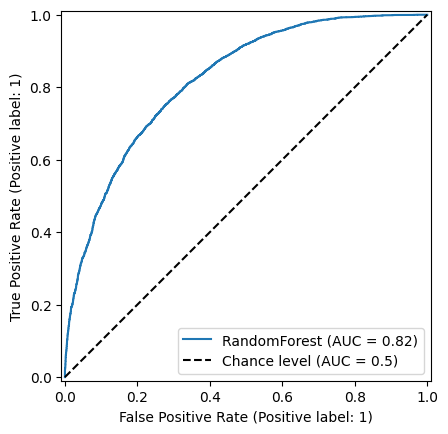

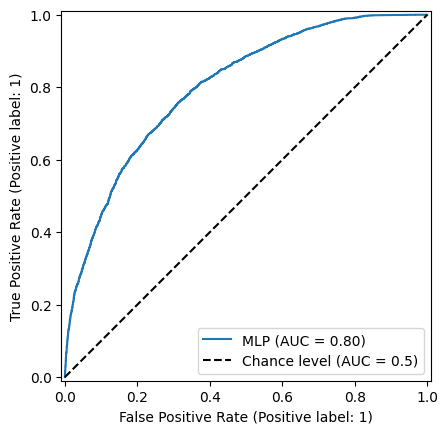

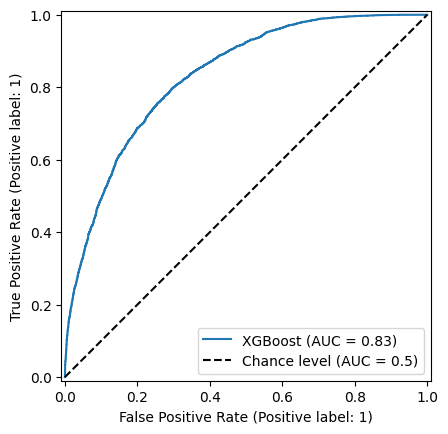

In [ ]:
X_full = X_tv
y_full = y_tv
X_test = test_df.drop(columns=[TARGET])
y_test = test_df[TARGET].astype(int)

final_scores = []
for name, pipe in best_pipes.items():
    print(f'{name} — обучение на train + validation')
    pipe.fit(X_full, y_full)

    proba = pipe.predict_proba(X_test)[:,1]
    pred  = (proba >= 0.5).astype(int)

    RocCurveDisplay.from_predictions(y_test, proba, name=name, plot_chance_level=True)

    final_scores.append({
        'Model': name,
        'ROC_AUC_test': roc_auc_score(y_test, proba),
        'F1_test': f1_score(y_test, pred),
        'Acc_test': accuracy_score(y_test, pred)
    })

## Итоговые метрики точности

In [ ]:
pd.DataFrame(final_scores).set_index('Model').sort_values('ROC_AUC_test', ascending=False)

,ROC_AUC_test,F1_test,Acc_test
Model,,,
XGBoost,0.831268,0.791947,0.754722
RandomForest,0.820544,0.776160,0.742420
MLP,0.800930,0.765197,0.727599
LogReg,0.759266,0.705937,0.691466
kNN,0.758708,0.744144,0.696309


По итоговым метрикам получаем, что самыми точными моделями у нас получились XGBoost и RandomForest, у которых по всем метрикам точности самые лучшие показатели. Также MLP достаточно близка к ним. Если же вернуться к выбору гиперпараметров, то можно заметить, что их подбор для случайного леса длился более чем в 10 раз дольше, чем у XGBoost. В данном случае, конечно, не так критично, ведь в целом не было выбрано много параметров для подбора, однако в реальных условиях с намного большим набором данных и гиперпараметров потребуется огромное количество ресурсов, поэтому, XGBoost является лучшей в данном случае моделью, даже учитывая близкие показания по метрикам